In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import string
import re
import nltk
import emoji
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.tokenize import sent_tokenize, word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sodjs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sodjs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

In [305]:
df = pd.read_csv('C:/Users/sodjs/RL/data/sentimentdataset.csv')
df.head(2)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8


In [4]:
df.duplicated().sum()

np.int64(0)

In [308]:
df1 = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags', 'Day', 'Hour'])
df1['Timestamp'] = pd.to_datetime(df['Timestamp'])
df1['Sentiment'] = df1['Sentiment'].str.lower().str.strip()
df1.head(2)

,Text,Sentiment,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month
0,Enjoying a beautiful day at the park! ...,positive,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1
1,Traffic was terrible this morning. ...,negative,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1


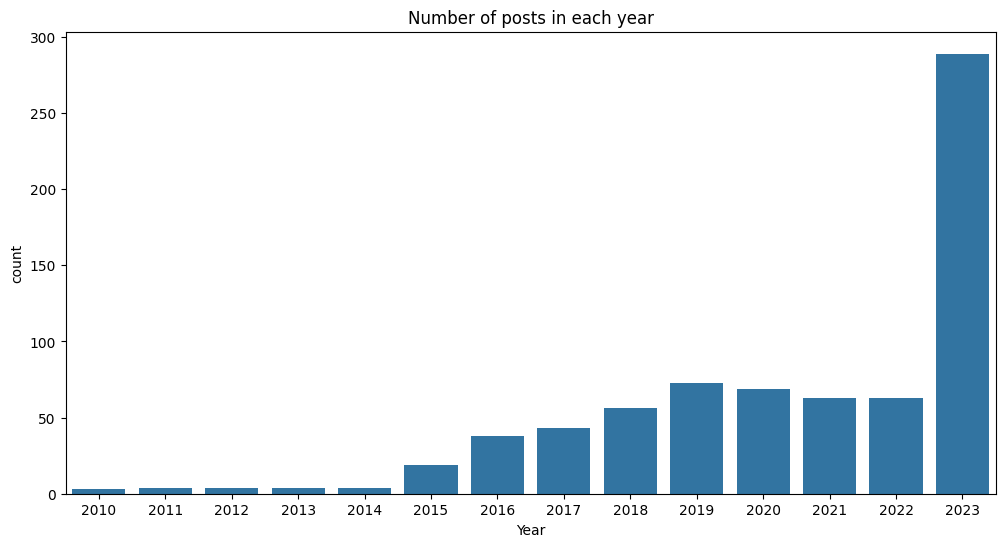

In [309]:
plt.figure(figsize=(12,6))
sns.countplot(x='Year', data=df1)
plt.title('Number of posts in each year')
plt.show()

In [310]:
df1.describe()

,Timestamp,Retweets,Likes,Year,Month
count,732,732.000000,732.000000,732.000000,732.000000
mean,2020-12-08 21:37:38.196721408,21.508197,42.901639,2020.471311,6.122951
min,2010-05-15 15:30:00,5.000000,10.000000,2010.000000,1.000000
25%,2019-03-08 17:27:30,17.750000,34.750000,2019.000000,3.000000
50%,2021-09-20 14:30:00,22.000000,43.000000,2021.000000,6.000000
75%,2023-02-26 11:48:45,25.000000,50.000000,2023.000000,9.000000
max,2023-10-22 20:45:00,40.000000,80.000000,2023.000000,12.000000
std,NaN,7.061286,14.089848,2.802285,3.411763


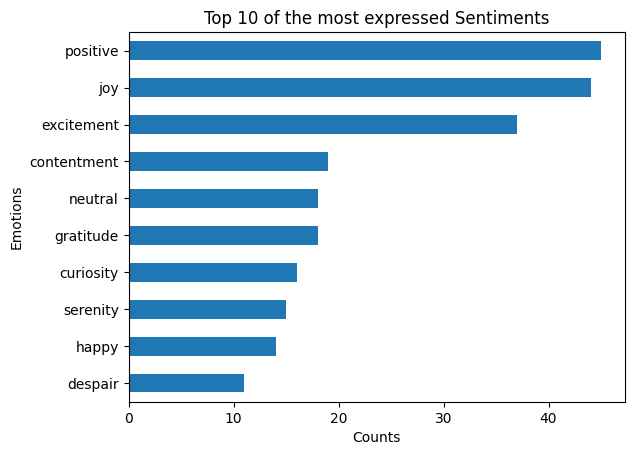

In [311]:
df1['Sentiment'].value_counts().nlargest(10).iloc[::-1].plot(kind='barh')
plt.title('Top 10 of the most expressed Sentiments')
plt.xlabel('Counts')
plt.ylabel('Emotions')
plt.show()

In [312]:
df1['Platform'].value_counts()

Platform
Instagram     258
Facebook      231
Twitter       128
Twitter       115
Name: count, dtype: int64

In [313]:
def process1_text(text):
    "Remove url, punctuations, stopwords"
    url_removed = re.sub(r'http\S+|www\S+', '', text)
    punc_removed = url_removed.translate(str.maketrans('', '', string.punctuation))
    split_words = punc_removed.split()
    filtered_word = [word for word in split_words if word.lower() not in stopwords_eng]
    return ' '.join(filtered_word)

def demojize_text(text):
    "demoji, lemmatize text"
    return emoji.demojize(text)
 
df1['Text'] = df1['Text'].apply(process1_text)
df1['Text'] = df1['Text'].apply(demojize_text)
df1.head()

,Text,Sentiment,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month
0,Enjoying beautiful day park,positive,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1
1,Traffic terrible morning,negative,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1
2,finished amazing workout :flexed_biceps:,positive,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1
3,Excited upcoming weekend getaway,positive,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1
4,Trying new recipe dinner tonight,neutral,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,1


In [314]:
def pos_tag_convert(nltk_tag: str)->str:
    "Used for Lemmatization"
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [315]:
df1['Text_Lem'] = df1['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word, pos_tag_convert(word)) for word in x.split()]))
df1.head()

,Text,Sentiment,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Text_Lem
0,Enjoying beautiful day park,positive,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Enjoying beautiful day park
1,Traffic terrible morning,negative,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Traffic terrible morning
2,finished amazing workout :flexed_biceps:,positive,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1,finished amazing workout :flexed_biceps:
3,Excited upcoming weekend getaway,positive,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1,Excited upcoming weekend getaway
4,Trying new recipe dinner tonight,neutral,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,1,Trying new recipe dinner tonight


In [316]:
df2 = df1.drop(columns=['Timestamp', 'User', 'Platform', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Text'])
df2.head()

,Sentiment,Text_Lem
0,positive,Enjoying beautiful day park
1,negative,Traffic terrible morning
2,positive,finished amazing workout :flexed_biceps:
3,positive,Excited upcoming weekend getaway
4,neutral,Trying new recipe dinner tonight


In [317]:
sentiment_encoded = pd.get_dummies(df2['Sentiment'])
fin_df = pd.concat([df2['Text_Lem'], sentiment_encoded], axis=1)

print("Number of columns:", len(fin_df.columns))
print("List of sentiment columns:", list(sentiment_encoded.columns))
fin_df.head()

Number of columns: 192
List of sentiment columns: ['acceptance', 'accomplishment', 'admiration', 'adoration', 'adrenaline', 'adventure', 'affection', 'amazement', 'ambivalence', 'amusement', 'anger', 'anticipation', 'anxiety', 'appreciation', 'apprehensive', 'arousal', 'artisticburst', 'awe', 'bad', 'betrayal', 'bitter', 'bitterness', 'bittersweet', 'blessed', 'boredom', 'breakthrough', 'calmness', 'captivation', 'celebration', 'celestial wonder', 'challenge', 'charm', 'colorful', 'compassion', 'compassionate', 'confidence', 'confident', 'confusion', 'connection', 'contemplation', 'contentment', 'coziness', 'creative inspiration', 'creativity', 'culinary adventure', 'culinaryodyssey', 'curiosity', 'darkness', 'dazzle', 'desolation', 'despair', 'desperation', 'determination', 'devastated', 'disappointed', 'disappointment', 'disgust', 'dismissive', 'dreamchaser', 'ecstasy', 'elation', 'elegance', 'embarrassed', 'emotion', 'emotionalstorm', 'empathetic', 'empowerment', 'enchantment', 'ene

,Text_Lem,acceptance,accomplishment,admiration,adoration,adrenaline,adventure,affection,amazement,ambivalence,...,tranquility,triumph,vibrancy,whimsy,whispers of the past,winter magic,wonder,wonderment,yearning,zest
0,Enjoying beautiful day park,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Traffic terrible morning,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,finished amazing workout :flexed_biceps:,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Excited upcoming weekend getaway,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Trying new recipe dinner tonight,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Positive

In [318]:
y = sentiment_encoded.values
positive_indices = y[:, list(sentiment_encoded.columns).index('positive')].astype(int)
X = df2['Text_Lem'].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=30)

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, 
    positive_indices, 
    test_size=0.2, 
    random_state=42,
    stratify=positive_indices
)
print("distribution in training set:")
print(pd.Series(y_train).value_counts())

distribution in training set:
0    549
1     36
Name: count, dtype: int64


In [320]:
model = Sequential([
    Embedding(5000, 100),
    LSTM(32),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

neg_count = np.sum(y_train == 0)
pos_count = np.sum(y_train == 1)
total = len(y_train)
class_weight = {
    0: total / (2 * neg_count),
    1: total / (2 * pos_count)
}

print("Class weights:", class_weight)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Class weights: {0: np.float64(0.5327868852459017), 1: np.float64(8.125)}


In [321]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)

train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'\nTrain accuracy: {train_acc*100:.2f}%')
print(f'Test accuracy: {test_acc*100:.2f}%')

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1519 - loss: 0.6080 - val_accuracy: 0.1795 - val_loss: 0.7267
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2250 - loss: 0.6561 - val_accuracy: 0.4957 - val_loss: 0.7217
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6472 - loss: 0.5610 - val_accuracy: 0.5299 - val_loss: 0.7643
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7162 - loss: 0.4659 - val_accuracy: 0.7521 - val_loss: 0.6165
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8917 - loss: 0.2891 - val_accuracy: 0.8889 - val_loss: 0.3822
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9888 - loss: 0.1335 - val_accuracy: 0.8889 - val_loss: 0.2813
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9910 - loss: 0.0584 - val_accuracy: 0.8889 - val_loss: 0.2826
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9970 - loss: 0.0264 - val_accuracy: 0.8974 - val_los

In [322]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, pred_binary))
print("\nClassification Report: ")
print(classification_report(y_test, pred_binary))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

Confusion Matrix: 
[[132   6]
 [  5   4]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       138
           1       0.40      0.44      0.42         9

    accuracy                           0.93       147
   macro avg       0.68      0.70      0.69       147
weighted avg       0.93      0.93      0.93       147



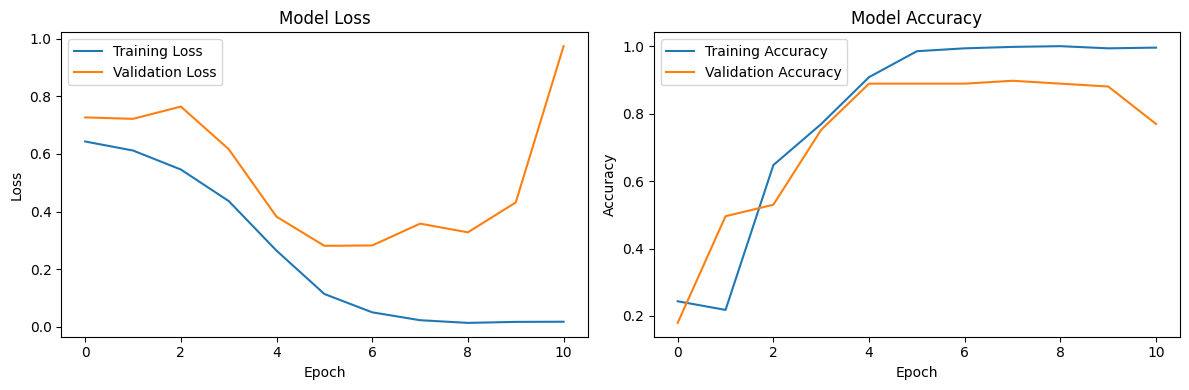

In [323]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Joy

In [324]:
y = sentiment_encoded.values
joy_indices = y[:, list(sentiment_encoded.columns).index('joy')].astype(int)
X = df2['Text_Lem'].values

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X)

X_seq = tokenizer.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=30)

X_train, X_test, y_train, y_test = train_test_split(
    X_pad, 
    joy_indices, 
    test_size=0.2, 
    random_state=42,
    stratify=joy_indices
)
print("distribution in training set:")
print(pd.Series(y_train).value_counts())

distribution in training set:
0    550
1     35
Name: count, dtype: int64


In [329]:
no_joy_count = np.sum(y_train == 0)
joy_count = np.sum(y_train == 1)
total = len(y_train)

class_weight = {
    0: total / (2 * no_joy_count),
    1: total / (2 * joy_count)
}

print("\nClass weights:", class_weight)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight,
    callbacks=[early_stop],
    verbose=1
)


Class weights: {0: np.float64(0.5318181818181819), 1: np.float64(8.357142857142858)}
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9518 - loss: 0.5611 - val_accuracy: 0.8632 - val_loss: 0.5121
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9575 - loss: 0.5446 - val_accuracy: 0.9145 - val_loss: 0.4270
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9816 - loss: 0.4214 - val_accuracy: 0.8547 - val_loss: 0.3945
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9856 - loss: 0.2185 - val_accuracy: 0.8547 - val_loss: 0.3691
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9806 - loss: 0.1072 - val_accuracy: 0.8632 - val_loss: 0.3322


In [326]:
train_loss, train_acc = model.evaluate(X_train, y_train)
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'\nTrain accuracy: {train_acc*100:.2f}%')
print(f'Test accuracy: {test_acc*100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9407 - loss: 0.4556
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9321 - loss: 0.4642

Train accuracy: 93.16%
Test accuracy: 92.52%


In [327]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

from sklearn.metrics import classification_report, confusion_matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, pred_binary))
print("\nClassification Report:")
print(classification_report(y_test, pred_binary))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Confusion Matrix:
[[136   2]
 [  9   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       138
           1       0.00      0.00      0.00         9

    accuracy                           0.93       147
   macro avg       0.47      0.49      0.48       147
weighted avg       0.88      0.93      0.90       147



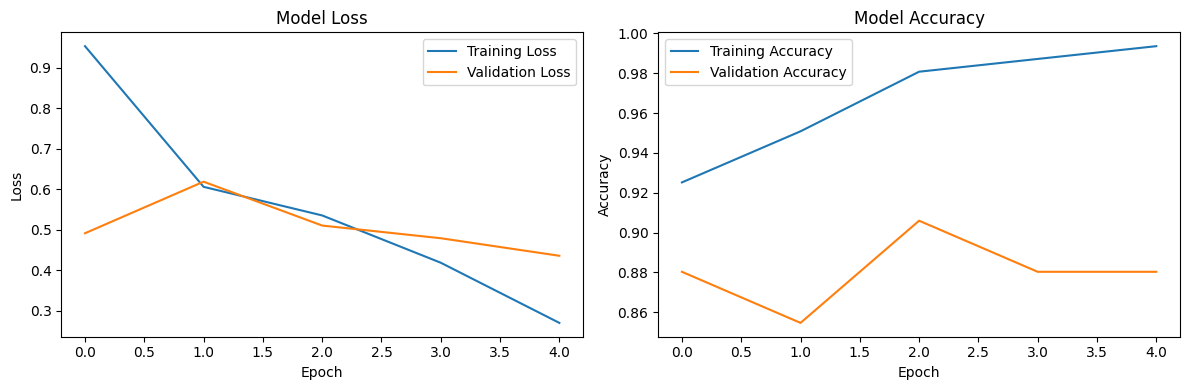

In [328]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [331]:
y = sentiment_encoded.values
sentiment_sums = pd.Series(y.sum(axis=0), index=sentiment_encoded.columns)
top_10_sentiments = sentiment_sums.nlargest(10).index
y_filtered = y[:, [list(sentiment_encoded.columns).index(sent) for sent in top_10_sentiments]]

max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(df2['Text_Lem'])

X = tokenizer.texts_to_sequences(df2['Text_Lem'])

max_length = 30

X_pad = pad_sequences(X, maxlen=max_length, padding='post', truncating='post')

print("Original number of categories:", y.shape[1])
print("Filtered number of categories:", y_filtered.shape[1])
print("\nTop 10 sentiments:")
for sent, count in sentiment_sums.nlargest(10).items():
    print(f"{sent}: {count}")

Original number of categories: 191
Filtered number of categories: 10

Top 10 sentiments:
positive: 45
joy: 44
excitement: 37
contentment: 19
gratitude: 18
neutral: 18
curiosity: 16
serenity: 15
happy: 14
despair: 11


In [332]:
from tensorflow.keras.layers import Bidirectional

X_train, X_test, y_train, y_test = train_test_split(X_pad, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered.argmax(axis=1))
model = Sequential([
    Embedding(max_words, 50),
    Bidirectional(LSTM(32)),                
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='sigmoid'),
    Dense(10, activation='softmax')
])

In [333]:
optimizer = Adam(learning_rate=0.01)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [334]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    min_delta=0.001
)

In [335]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001
)

In [336]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.2838 - loss: 0.7203 - val_accuracy: 0.0940 - val_loss: 0.8383 - learning_rate: 0.0100
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2335 - loss: 0.7366 - val_accuracy: 0.0940 - val_loss: 0.8254 - learning_rate: 0.0100
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4990 - loss: 0.6729 - val_accuracy: 0.7009 - val_loss: 0.8249 - learning_rate: 0.0100
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7415 - loss: 0.7028 - val_accuracy: 0.7009 - val_loss: 0.8161 - learning_rate: 0.0100
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7181 - loss: 0.7600 - val_accuracy: 0.7009 - val_loss: 0.8173 - learning_rate: 0.0100


In [337]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0582 - loss: 0.6959 

Test accuracy: 6.12%


In [338]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [339]:
predictions = model.predict(X_test)
pred_binary = (predictions > 0.5).astype(int)

for i, sentiment in enumerate(top_10_sentiments):
    print(f"\n{sentiment}:")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test[:, i], pred_binary[:, i]))
    print("\nClassification Report:")
    print(classification_report(y_test[:, i], pred_binary[:, i], zero_division=0))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

positive:
Confusion Matrix:
[[141   0]
 [  6   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.96      1.00      0.98       141
        True       0.00      0.00      0.00         6

    accuracy                           0.96       147
   macro avg       0.48      0.50      0.49       147
weighted avg       0.92      0.96      0.94       147


joy:
Confusion Matrix:
[[138   0]
 [  9   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97       138
        True       0.00      0.00      0.00         9

    accuracy                           0.94       147
   macro avg       0.47      0.50      0.48       147
weighted avg       0.88      0.94      0.91       147


excitement:
Confusion Matrix:
[[140   0]
 [  7   0]]

Classification Report:
              precision    recall  f1-score   support

       False       0.95     

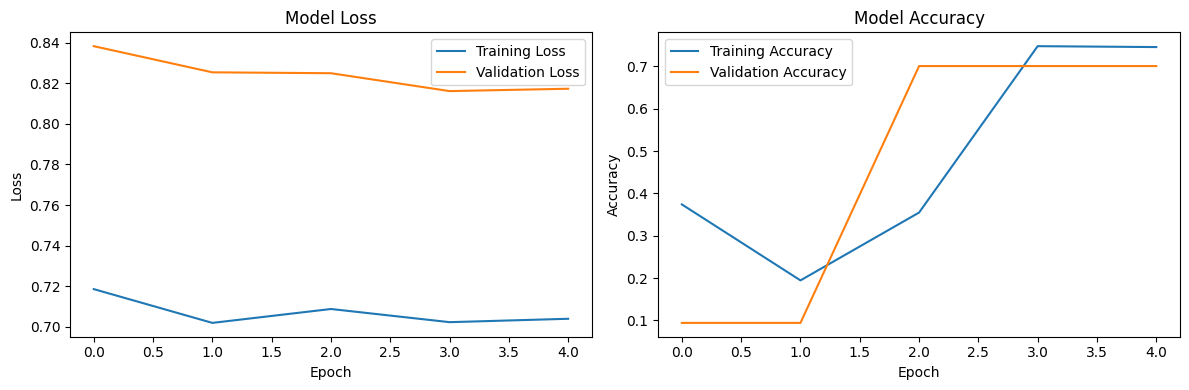

In [340]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**Caveat**

Since there is a Class Imbalance problem, it causes the lower accuracy and high loss function for training.
Regularization can be considered.
e.g.
Top 10 sentiments:
positive: 45
joy: 44
excitement: 37
contentment: 19
gratitude: 18
neutral: 18
curiosity: 16
serenity: 15
happy: 14
despair: 11
